In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import gym
import torch
import torch.nn as nn

from env.p2p_elec_market_3 import TradingSession as TradingSession3

# Price dynamics:

In [2]:
prices = {}

env = TradingSession3(action_space_config = 'discrete', num_mutual_sessions = 3, dyn_control = 'minus')
env.reset()
done = False

prices[3] = np.array(env.session_prices)

while done == False:
    _, _, done, _ = env.step(0)
    prices[3] = np.vstack([prices[3], env.session_prices])

C:\123\thesis\p2p_DQN\venv\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


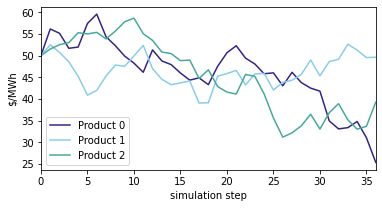

In [3]:
plt.style.use(['C:/Users/lub/.matplotlib/stylelib/muted.mplstyle',              
               'C:/Users/lub/.matplotlib/stylelib/no-latex.mplstyle'])

fig, ax = plt.subplots(1, figsize = [6,3])

ax.plot(prices[3])
ax.set_xlim([0, len(prices[3]) - 1])
ax.set_ylabel('$/MWh')
ax.set_xlabel('simulation step')
ax.legend(['Product 0', 'Product 1', 'Product 2'])
plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.savefig('prices.pdf', bbox_inches='tight')

# Training curves

In [50]:
sims = ['runs/Jul15_12-41-11_n-62-21-51/reward_100.csv', 
        'runs/Jul15_12-41-30_n-62-21-65/reward_100.csv',
        'runs/Jul15_12-41-51_n-62-21-66/reward_100.csv']

DQN = {}

for sim in sims:
    DQN[sim] = pd.read_csv(sim)

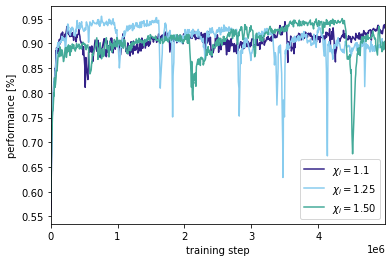

In [52]:
fig, axs = plt.subplots(1)

for i, p in enumerate(sims):
    axs.plot(DQN[p].values[:,1], DQN[p].values[:,2])

axs.set_xlim([0, DQN[p].values[-1,1]])
axs.set_ylabel('performance [%]')
axs.set_xlabel('training step')
axs.legend([r'$\chi_i = 1.1$', r'$\chi_i = 1.25$',r'$\chi_i = 1.50$'], loc = 'lower right')
plt.subplots_adjust(wspace=0.02, hspace=0.02)
plt.savefig('train.pdf',bbox_inches='tight')

# Testing the models

In [6]:
class DQN(nn.Module):
    """Deep Q-network with target network"""

    def __init__(self, n_inputs, n_outputs):
        super(DQN, self).__init__()
        # network
        self.fc = nn.Sequential(
                    nn.Linear(n_inputs, 64),
                    nn.ReLU(),
                    nn.Linear(64, 64),
                    nn.ReLU(),
                    nn.Linear(64, n_outputs)
        )


    def forward(self, x):
        x = x.float()
        return self.fc(x)

In [7]:
class BaselinePolicy:
    """
    Policy that selects action based in current environment state.
    If holdings_quantity does not exceed the boundary, place order with constant value in session with min price.
    If holdings_quantity exceeds the boundary, do not place any order.
    Inputs:
        - current_state: dictionary with current state of the environment
        - constant_order: constant value of the order whem holdings_quantity do not exceed the boundary
        - boundary: boundary of the environment
    """
    def __init__(self, mode, boundary, constant_order=1, action_space_config='discrete'):
        self.constant_order = constant_order
        self.boundary = boundary
        self.mode = mode
        self.action_space_config = action_space_config

    def select_action(self, env):
        self.session_prices = env.session_prices
        self.holdings_quantity = env.holdings_quantity

        if np.sum(self.holdings_quantity) + env.constant_order > self.boundary:
            if self.action_space_config == 'continous':
                action = np.zeros(len(self.holdings_quantity))
                return action
            elif self.action_space_config == 'discrete':
                return np.array([2*len(self.session_prices)])

        else:
            if self.mode == 'min_price':
                idx_min_price = np.argmin(self.session_prices)
                if self.action_space_config == 'continous':
                    action[idx_min_price] = self.constant_order
                    return action
                elif self.action_space_config == 'discrete':
                    return np.array([idx_min_price])

            elif self.mode == 'random':
                idx_random = np.random.randint(0,len(self.session_prices)-1)
                if self.action_space_config == 'continous':
                    action[idx_random] = self.constant_order
                    return action
                elif self.action_space_config == 'discrete':
                    return np.array([idx_random])


# Config and seeds:

In [8]:
num_episodes = 1000
seeds = np.random.randint(num_episodes*2, size=num_episodes)
nums_mutual_sessions = [3]
perf = {}
envs = [TradingSession3(action_space_config = 'discrete', num_mutual_sessions = 3, dyn_control = 'minus', pref_const = 1.10),
        TradingSession3(action_space_config = 'discrete', num_mutual_sessions = 3, dyn_control = 'minus', pref_const = 1.25),
        TradingSession3(action_space_config = 'discrete', num_mutual_sessions = 3, dyn_control = 'minus', pref_const = 1.50)]

sims = ['random-{}'.format(i) for i in range(len(envs))] + ['min_price-{}'.format(i) for i in range(len(envs))] + ['DQN-{}'.format(i) for i in range(len(envs))]
obs_dict = dict.fromkeys(sims)
actions_dict = dict.fromkeys(sims)
returns_dict = dict.fromkeys(sims)
q_values_dict = dict.fromkeys(sims)

C:\123\thesis\p2p_DQN\venv\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


# Random baseline

In [9]:
mode = 'random'
for i, env in enumerate(envs):
    performances = []
    obs = env.reset()
    obs_dict[mode + '-{}'.format(i)] = obs
    policy = BaselinePolicy(mode = mode, boundary = env.boundary, action_space_config = 'discrete')
    for s, seed in enumerate(seeds):
        np.random.seed(seed)
        obs = env.reset()
        done = False
        rewards = np.array(env.reward)
        while done == False:
            obs_dict[mode + '-{}'.format(i)] = np.vstack([obs_dict[mode + '-{}'.format(i)], obs])
            action = policy.select_action(env)
            actions_dict[mode + '-{}'.format(i)] = np.vstack([actions_dict[mode + '-{}'.format(i)], action])
            obs, reward, done, _ = env.step(action)
            rewards = np.append(rewards, reward)
        policy_reward = np.add.accumulate(rewards)[-1]
        returns_dict[mode + '-{}'.format(i)] = np.vstack([returns_dict[mode + '-{}'.format(i)], policy_reward])
        policy_performance = policy_reward/env.optimal_strategy_reward
        performances.append(policy_performance)
    perf[mode + '-{}'.format(i)] = performances
    avg_per = np.average(performances)

    print("{} performance: {}%". format(mode, round(100*avg_per, 2)))

random performance: 68.12%
random performance: 65.54%
random performance: 58.44%


# Min price

In [10]:
mode = 'min_price'
for i, env in enumerate(envs):
    performances = []
    obs = env.reset()
    obs_dict[mode + '-{}'.format(i)] = obs
    policy = BaselinePolicy(mode = mode, boundary = env.boundary, action_space_config = 'discrete')
    for s, seed in enumerate(seeds):
        np.random.seed(seed)
        env.reset()
        done = False
        rewards = np.array(env.reward)
        while done == False:
            obs_dict[mode + '-{}'.format(i)] = np.vstack([obs_dict[mode + '-{}'.format(i)], obs])
            action = policy.select_action(env)
            actions_dict[mode + '-{}'.format(i)] = np.vstack([actions_dict[mode + '-{}'.format(i)], action])
            obs, reward, done, _ = env.step(action)
            rewards = np.append(rewards, reward)
        policy_reward = np.add.accumulate(rewards)[-1]
        returns_dict[mode + '-{}'.format(i)] = np.vstack([returns_dict[mode + '-{}'.format(i)], policy_reward])
        policy_performance = policy_reward/env.optimal_strategy_reward
        performances.append(policy_performance)
    perf[mode + '-{}'.format(i)] = performances
    avg_per = np.average(performances)

    print("{} performance: {}%". format(mode, round(100*avg_per, 2)))

min_price performance: 73.45%
min_price performance: 73.33%
min_price performance: 69.37%


# DQN

In [12]:
mode = 'DQN'
model_path = ['runs/Jul15_12-41-11_n-62-21-51/model_10_part_3.dat', 
                'runs/Jul15_12-41-30_n-62-21-65/model_25_part_3.dat',
                'runs/Jul15_12-41-51_n-62-21-66/model_50_part_3.dat']

for i, env in enumerate(envs):
    performances = []
    obs = env.reset()
    obs_dict[mode + '-{}'.format(i)] = obs    
    net = DQN(env.observation_space.shape[0], env.action_space.n)
    net.load_state_dict(torch.load(model_path[i], map_location=lambda storage, loc: storage))
    
    for s, seed in enumerate(seeds):
        np.random.seed(seed)
        obs = env.reset()
        done = False
        rewards = np.array(env.reward)
        while done == False:
            obs_dict[mode + '-{}'.format(i)] = np.vstack([obs_dict[mode + '-{}'.format(i)], obs])
            state_v = torch.tensor(np.array([obs], copy=False))
            q_vals = net(state_v).data.numpy()[0]
            q_values_dict[mode + '-{}'.format(i)] = np.vstack([q_values_dict[mode + '-{}'.format(i)], q_vals.max()])
            action = np.argmax(q_vals)
            actions_dict[mode + '-{}'.format(i)] = np.vstack([actions_dict[mode + '-{}'.format(i)], action])
            obs, reward, done, _ = env.step(action)
            rewards = np.append(rewards, reward)
            returns_dict[mode + '-{}'.format(i)] = np.vstack([returns_dict[mode + '-{}'.format(i)], reward])
        policy_reward = np.add.accumulate(rewards)[-1]
        policy_performance = policy_reward/env.optimal_strategy_reward
        performances.append(policy_performance)
    perf[mode + '-{}'.format(i)] = performances
    avg_per = np.average(performances)

    print("DQN-{} performance: {}%". format(i, round(100*avg_per, 2)))

DQN-0 performance: 94.63%
DQN-1 performance: 94.79%
DQN-2 performance: 92.9%


# Performances

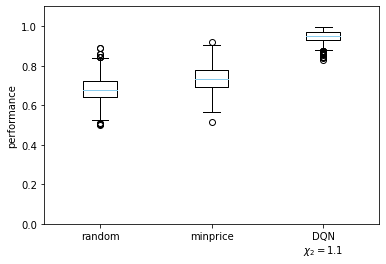

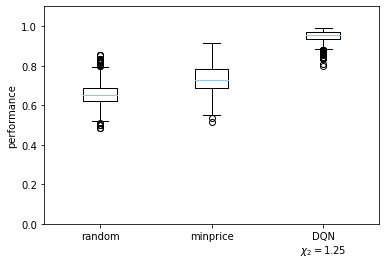

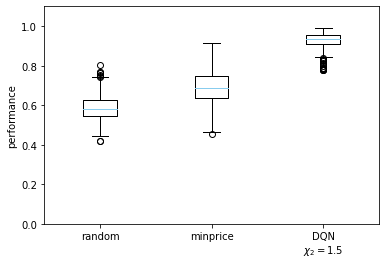

In [23]:
for i, p in enumerate([1.10, 1.25, 1.50]):
    fig, axs = plt.subplots(1)
    axs.boxplot(np.vstack([perf['random-{}'.format(i)], perf['min_price-{}'.format(i)], perf['DQN-{}'.format(i)]]).T)
    axs.set_ylim([0,1.1])
    axs.set_xticklabels(['random', 'minprice', 'DQN\n'+ r'$\chi_2 = {}$'.format(p)])
    axs.set_ylabel('performance')
    plt.savefig('performance_{}.pdf'.format(p),bbox_inches='tight')

# Visualizing policy

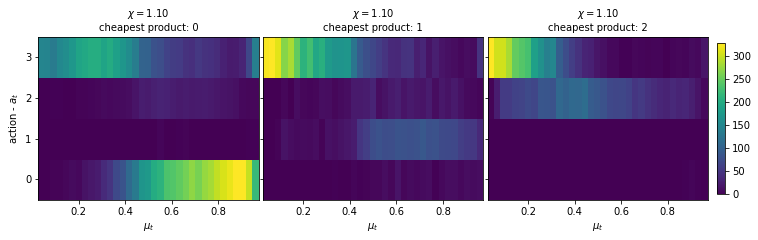

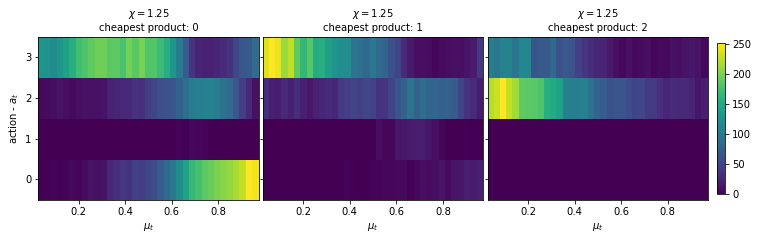

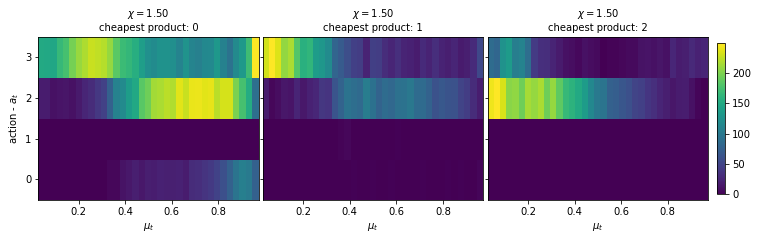

In [53]:
gammas = ['DQN-0', 'DQN-1', 'DQN-2']
g = ['1.10', '1.25', '1.50']

for g, gamma in zip(g, gammas):
    policy_df = pd.DataFrame(np.hstack([obs_dict[gamma][1:,:],actions_dict[gamma][1:,:]]))
    p0_df = policy_df[(policy_df.iloc[:,0] < policy_df.iloc[:,1]) & (policy_df.iloc[:,0] < policy_df.iloc[:,2])]
    p1_df = policy_df[(policy_df.iloc[:,1] < policy_df.iloc[:,0]) & (policy_df.iloc[:,1] < policy_df.iloc[:,2])]
    p2_df = policy_df[(policy_df.iloc[:,2] < policy_df.iloc[:,1]) & (policy_df.iloc[:,2] < policy_df.iloc[:,0])]
    
    #Getting data
    x=p0_df.iloc[:,4]
    y=p0_df.iloc[:,5]

    # Creating figure
    fig, axs = plt.subplots(1, 3, figsize =(12, 3), sharey = True, sharex = True)

    # Creating bins 
    x_min = np.min(x) 
    x_max = np.max(x) 

    y_min = np.min(y) 
    y_max = np.max(y) 

    x_bins = np.linspace(x_min, x_max, 36) 
    y_bins = np.linspace(-0.5, 3.5, 5)

    # Creating plot 
    axs[0].hist2d(x, y, bins =[x_bins, y_bins]) 

    axs[0].set_title(r'$\chi = {}$'.format(g) + '\ncheapest product: 0', size = 'medium')
    axs[0].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[0].set_xlabel(r'$\mu_t$')
    axs[0].set_ylabel(r'action - $a_t$')
        
    #Getting data
    x=p1_df.iloc[:,4]
    y=p1_df.iloc[:,5]

    # Creating bins 
    x_min = np.min(x) 
    x_max = np.max(x) 

    y_min = np.min(y) 
    y_max = np.max(y) 

    x_bins = np.linspace(x_min, x_max, 36) 
    y_bins = np.linspace(-0.5, 3.5, 5)

    # Creating plot 
    axs[1].hist2d(x, y, bins =[x_bins, y_bins]) 

    axs[1].set_title(r'$\chi = {}$'.format(g) + '\ncheapest product: 1', size = 'medium')
    axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[1].set_xlabel(r'$\mu_t$')
    
    #Getting data
    x=p2_df.iloc[:,4]
    y=p2_df.iloc[:,5]

    # Creating bins 
    x_min = np.min(x) 
    x_max = np.max(x) 

    y_min = np.min(y) 
    y_max = np.max(y) 

    x_bins = np.linspace(x_min, x_max, 36) 
    y_bins = np.linspace(-0.5, 3.5, 5)

    # Creating plot 
    h = axs[2].hist2d(x, y, bins =[x_bins, y_bins]) 
    axs[2].set_title(r'$\chi = {}$'.format(g) + '\ncheapest product: 2', size = 'medium')
    axs[2].yaxis.set_major_locator(MaxNLocator(integer=True))
    axs[2].set_xlabel(r'$\mu_t$')
    
    cbaxes = fig.add_axes([0.91, 0.15, 0.01, 0.7]) 
    #cbar = fig.colorbar(h[3], ax=axs[:], cax = cbaxes, ticks=[0, 346/2, 346])
    #cbar.ax.set_yticklabels(['low', 'medium', 'high'])
    cbar = fig.colorbar(h[3], ax=axs[:], cax = cbaxes)    
    
    plt.subplots_adjust(wspace=0.02, hspace=0.02)
    plt.savefig('policy_{}.pdf'.format(g), bbox_inches='tight')

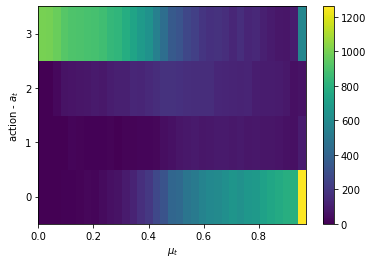

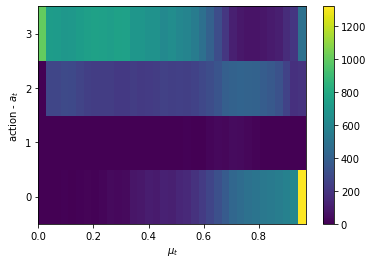

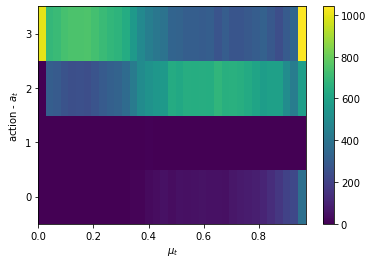

In [16]:
gammas = ['DQN-0', 'DQN-1', 'DQN-2']
g = ['1.10', '1.25', '1.50']

for g, gamma in zip(g, gammas):
    policy_df = pd.DataFrame(np.hstack([obs_dict[gamma][1:,:],actions_dict[gamma][1:,:]]))

    # Creating figure
    fig, axs = plt.subplots(1)

    #Getting data
    x=policy_df.iloc[:,4]
    y=policy_df.iloc[:,5]
    
    # Creating bins 
    x_min = np.min(x) 
    x_max = np.max(x) 

    y_min = np.min(y) 
    y_max = np.max(y) 

    x_bins = np.linspace(x_min, x_max, 36) 
    y_bins = np.linspace(-0.5, 3.5, 5)

    # Creating plot 
    h = axs.hist2d(x, y, bins =[x_bins, y_bins]) 

    #axs.set_title('cheapest product: 0', size = 'medium')
    axs.yaxis.set_major_locator(MaxNLocator(integer=True))
    axs.set_xlabel(r'$\mu_t$')
    axs.set_ylabel(r'action - $a_t$')
    
    cbar = fig.colorbar(h[3], ax=axs)
    plt.subplots_adjust(wspace=0.02, hspace=1.2)
    plt.savefig('policy_{}_B.pdf'.format(g), bbox_inches='tight')

In [48]:
import collections

gammas = ['DQN-0', 'DQN-1', 'DQN-2']
g = ['1.10', '1.25', '1.50']

for g, gamma in zip(g, gammas):
    actions_count = collections.Counter(actions_dict[gamma][1:,:].reshape(actions_dict[gamma][1:,:].shape[0]))
    print(g, actions_count)
    print(g, [(i, actions_count[i] / len(actions_dict[gamma][1:,:].reshape(actions_dict[gamma][1:,:].shape[0])) * 100.0) for i in actions_count])

1.10 Counter({3: 17354, 0: 13313, 2: 3758, 1: 1575})
1.10 [(3, 48.205555555555556), (0, 36.980555555555554), (2, 10.43888888888889), (1, 4.375)]
1.25 Counter({3: 17664, 2: 9685, 0: 8445, 1: 206})
1.25 [(3, 49.06666666666666), (0, 23.458333333333332), (2, 26.902777777777775), (1, 0.5722222222222222)]
1.50 Counter({3: 17222, 2: 16756, 0: 2001, 1: 21})
1.50 [(3, 47.83888888888889), (2, 46.544444444444444), (0, 5.558333333333334), (1, 0.05833333333333334)]
